In [1]:
# Import warnings library
import warnings 
# Set action = "ignore" to ignore warnings
warnings.filterwarnings(action= 'ignore')
%load_ext autoreload
%autoreload 2

from tqdm import tqdm 
import matplotlib.pyplot as plt
import requests
import geopandas as gpd
import pandas as pd
import geopy.distance
import numpy as np
from sympy import Point, Polygon
from shapely.geometry import Polygon, LineString, Point
import time

import geojson
from geopy.point import Point
import re
import pydawa

from pyproj import Geod
from shapely.geometry import Point, LineString
from shapely.ops import nearest_points
geod = Geod(ellps="WGS84")  # Your data may be from a different Geod.

import functions as fu

# Get the borders

In [2]:
data = requests.get('https://api.dataforsyningen.dk/kommuner?format=geojson')
gdf = gpd.GeoDataFrame.from_features(data.json()["features"])

# Import Grundskyldspromillen

In [3]:
grundskyld = pd.read_excel('kmdata/kmdata_all.xlsx')

In [4]:
beskatning = fu.noegletal('beskatning')

In [5]:
beskatningsgrundlag = fu.noegletal('beskatningsgrundlag')

In [6]:
crime1 = fu.noegletal('crime1')

In [7]:
crime2 = fu.noegletal('crime2')

In [8]:
vuggestue = fu.noegletal('daginstitutioner0-2')

In [9]:
børnehave = fu.noegletal('daginstitutioner3-5')

In [10]:
dagpleje = fu.noegletal('dagpleje0-2')

In [11]:
klassekvotient = fu.noegletal('klassekvotient')

In [12]:
kultur = fu.noegletal('kultur')

In [13]:
socioindex = fu.noegletal('socioindex')

In [14]:
sportfritid = fu.noegletal('sportfritid')

In [15]:
udgifter = fu.noegletal('udgifter')

# Find neighbor municipal and distance

In [16]:
nabo= []

for i in range(gdf.shape[0]):
    rowi = gdf.iloc[i] # acces row
    namei  = rowi.navn
    geomi = rowi.geometry
    naboj = []
    for j in range(gdf.shape[0]):
        rowj = gdf.iloc[j] # acces row
        namej =rowj.navn
        if namei != namej:
            geomj = rowj.geometry
            isIntersection =geomi.intersection(geomj)
            if isIntersection.length>0:
                all_coords = isIntersection
                naboj.append([namej, all_coords])
                neighbor = (namei,namej)
    nabo.append(naboj)
        
gdf['nabo'] = nabo
   

# Load house data

In [17]:
var= ['Adresse', 'Købesum','Salgsdato','Salgstype','href', 'hrefbbr','geo_code', 'geo_location_raw','kommunenummer','boligtype', 'køkkenforhold','anvendelse','badeforhold', 'enhedsareal', 'antal_badeværelser','beboelsesareal', 'toiletforhold', 'værelser', 'antal_toiletter', 'energikode']


In [18]:

frames = [] # container
for i in range(1000,9999,10): 
    try:
        df = pd.read_csv(f'data_2007-2022/Final_{i}_{i+10-1}.csv') # save csv
        df = df[var]
        frames.append(df)
    except: pass
df = pd.concat(frames) # final dataset
print(f'Number of unique properties: {len(df.Adresse.unique())}')
b =df.shape[0]

df = df.dropna() # drop rows with nans'
a=df.shape[0]
print(f'Percent succes rate: {round(a/b*100,4)}')

Number of unique properties: 871090
Percent succes rate: 99.361


In [19]:
print(f'number of unique properties left: {len(df.Adresse.unique())}')

number of unique properties left: 865787


# remove all not regular free sald properties

In [20]:
before = df.shape[0]
df =df[df['Salgstype'].str.contains('frit')]
after = df.shape[0]
print(f'Number of properties removed {before-after} \n Number of properties left: {after}')

Number of properties removed 233767 
 Number of properties left: 1171263


# Remove all properties not suited for living

In [21]:
### Check om vi fjerner huse
before = df.shape[0]
df =df[df['boligtype'].str.contains('Egentlig beboelseslejlighed')]
after = df.shape[0]
print(f'Number of properties removed {before-after} \n Number of properties left: {after}')

Number of properties removed 145072 
 Number of properties left: 1026191


# Define lat and long

In [22]:
long= []
lat = []
for i in df['geo_code']:
    if i.__contains__("'"):
        i = i.replace("'", "")
    j = i.split(',')

    long.append(float(j[0][1:]))
    lat.append(float(j[1][:-1]))
    
df['long'] = long
df['lat'] = lat

In [23]:
from bs4 import BeautifulSoup, SoupStrainer
kom = 'https://danmarksadresser.dk/adressedata/kodelister/kommunekodeliste/'
get = requests.get(kom)
soup = BeautifulSoup(get.text, 'lxml')
ps = soup.find_all('p')
tab = ps[1]
nop = str(tab).replace('<p>', '')
nop_ = str(nop).replace('</p>', '')
nobr = nop_.replace('<br/>', '')
nosem = nobr.replace(':','')
fin = nosem.split(' ')
kode = fin[0::2]
kom = fin[1::2]
new_dict = {kode[i]: kom[i] for i in range(len(kom))}

# Add municipal column to house dataframe

In [24]:
kommune = []
for i in range(df.shape[0]):
    j = df.iloc[i].kommunenummer
    str_j = str(j)
    x = str_j.split(".")[0]
    kommune.append(f'0{x}')
df['kommunenummer'] = kommune

In [25]:


Kom = []
for i in df.kommunenummer:
    Kom.append(new_dict.get(i))
df['Kommune'] = Kom

# Subset dataframe to only contain does municipals with neighhbors

In [26]:

num_n =[]
for i in gdf.nabo:
    num_n.append(len(i))
gdf['num_n'] = num_n


gdf_n= gdf[gdf.num_n > 0]
df_n = df[df['Kommune'].isin(gdf_n.navn)]

# Find five errors

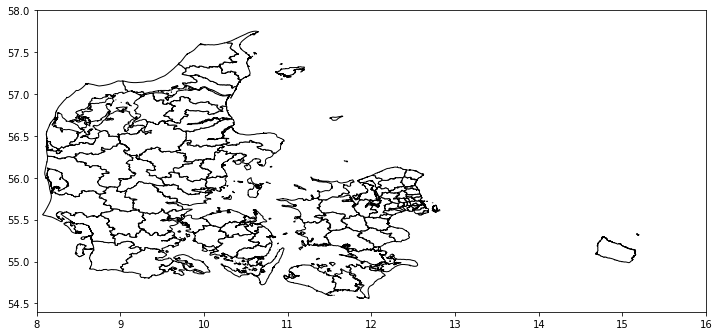

<Figure size 432x288 with 0 Axes>

In [27]:
fu.plot_borders(gdf, 'all_borders.png');

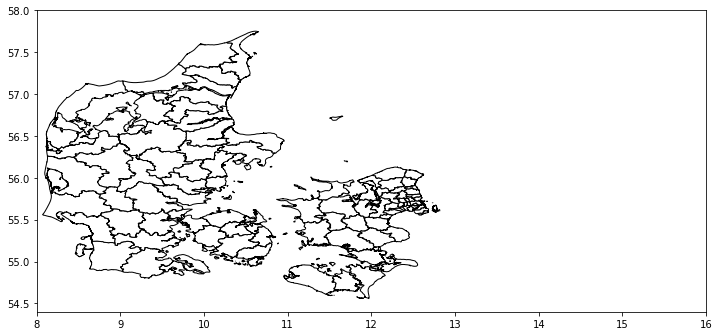

<Figure size 432x288 with 0 Axes>

In [28]:
fu.plot_borders(gdf_n, 'borders_with_neighbors.png');

# Find all municipalborders

In [29]:
neighbors = []
for i in range(gdf_n.shape[0]):
    rowi = gdf_n.iloc[i]
    namei = rowi.navn
    row_n = rowi.nabo
    for it, j in enumerate(row_n):
        set_n = (namei, j[0])
        neighbors.append(set_n)
list_of_neighbors= []
for i in neighbors:
    if (i[1],i[0]) in list_of_neighbors:
        pass
    else: list_of_neighbors.append(i)
print(f'Number of municipallity sets: {len(list_of_neighbors)}')     
    
df_list = pd.DataFrame(list_of_neighbors)
df_list.to_csv('list_of_neighbors.csv')


Number of municipallity sets: 186


# Define year 

In [30]:
df_n['Salgsdato'] = pd.to_datetime(df_n['Salgsdato'])
# add a column for Year
df_n['Year'] = df_n['Salgsdato'].dt.year
df_n

,Adresse,Købesum,Salgsdato,Salgstype,href,hrefbbr,geo_code,geo_location_raw,kommunenummer,boligtype,...,antal_badeværelser,beboelsesareal,toiletforhold,værelser,antal_toiletter,energikode,long,lat,Kommune,Year
1,"Holbergsgade 13A, st 1057 København K",5200000.0,2022-02-20,Handelstype Alm. frit salg,https://www.boliga.dk//salg/info/101/843688/EB...,https://www.boliga.dk//bbrinfo/eb4a9ee5-4acf-4...,"(55.67859043, 12.58911161)","Holbergsgade 13A, 1., 1057 København K",0101,Egentlig beboelseslejlighed,...,1,86,Vandskyllende toilet i enheden,3,1,-,55.678590,12.589112,København,2022
2,"Holbergsgade 13A, st 1057 København K",3200000.0,2018-04-01,Handelstype Alm. frit salg,https://www.boliga.dk//salg/info/101/843688/EB...,https://www.boliga.dk//bbrinfo/eb4a9ee5-4acf-4...,"(55.67859043, 12.58911161)","Holbergsgade 13A, 1., 1057 København K",0101,Egentlig beboelseslejlighed,...,1,86,Vandskyllende toilet i enheden,3,1,-,55.678590,12.589112,København,2018
3,"Holbergsgade 13A, st 1057 København K",2000000.0,2009-03-02,Handelstype Alm. frit salg,https://www.boliga.dk//salg/info/101/843688/EB...,https://www.boliga.dk//bbrinfo/eb4a9ee5-4acf-4...,"(55.67859043, 12.58911161)","Holbergsgade 13A, 1., 1057 København K",0101,Egentlig beboelseslejlighed,...,1,86,Vandskyllende toilet i enheden,3,1,-,55.678590,12.589112,København,2009
4,"Nyhavn 14, 4 1051 København K",10995000.0,2022-02-07,Handelstype Alm. frit salg,https://www.boliga.dk//salg/info/101/401960/41...,https://www.boliga.dk//bbrinfo/4163480c-a104-4...,"(55.67967824, 12.58993845)","Nyhavn 14, 1051 København K",0101,Egentlig beboelseslejlighed,...,2,169,Vandskyllende toilet i enheden,3,2,-,55.679678,12.589938,København,2022
5,"Nyhavn 14, 4 1051 København K",10200000.0,2021-04-08,Handelstype Alm. frit salg,https://www.boliga.dk//salg/info/101/401960/41...,https://www.boliga.dk//bbrinfo/4163480c-a104-4...,"(55.67967824, 12.58993845)","Nyhavn 14, 1051 København K",0101,Egentlig beboelseslejlighed,...,2,169,Vandskyllende toilet i enheden,3,2,-,55.679678,12.589938,København,2021
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
924,Krogstrupvej 167 8732 Hovedgård,2325000.0,2021-06-02,Handelstype Alm. frit salg,https://www.boliga.dk//salg/info/615/291167/FB...,https://www.boliga.dk//bbrinfo/fb1df190-6411-4...,"(55.96973503, 10.016999)","Krogstrupvej 167, Assendrup, 8732 Hovedgård",0615,Egentlig beboelseslejlighed,...,2,182,Vandskyllende toilet i enheden,6,2,-,55.969735,10.016999,Horsens,2021
925,"Horsensvej 4, 1 8732 Hovedgård",2450000.0,2007-12-10,Handelstype Alm. frit salg,https://www.boliga.dk//salg/info/615/292374/65...,https://www.boliga.dk//bbrinfo/65319b64-f29b-4...,"(55.94672159, 9.96197262)","Horsensvej 4, 1., 8732 Hovedgård",0615,Egentlig beboelseslejlighed,...,1,106,Vandskyllende toilet i enheden,3,1,-,55.946722,9.961973,Horsens,2007
926,Birkevænget 6 8732 Hovedgård,450000.0,2007-01-10,Handelstype Alm. frit salg,https://www.boliga.dk//salg/info/615/294461/E4...,https://www.boliga.dk//bbrinfo/e4924a4c-5b35-4...,"(55.94667912, 9.94904755)","Birkevænget 6, 8732 Hovedgård",0615,Egentlig beboelseslejlighed,...,3,201,Vandskyllende toilet i enheden,11,3,400 V el fra værk,55.946679,9.949048,Horsens,2007
927,N P Danmarksvej 34 8732 Hovedgård,515000.0,2010-09-01,Handelstype Alm. frit salg,https://www.boliga.dk//salg/info/615/294540/6E...,https://www.boliga.dk//bbrinfo/6ef96f0a-39f6-4...,"('55.9436120', '9.9474015')",N P Danmarksvej 34 8732 Hovedgård,0615,Egentlig beboelseslejlighed,...,2,172,Vandskyllende toilet i enheden,7,2,230 V el fra værk,55.943612,9.947401,Horsens,2010


# Find Grundskyldspromille for every property

In [31]:


df_n = fu.assign_noegletal(df_n, grundskyld, 'grundskylds_promille')

In [32]:
df_n = fu.assign_noegletal(df_n, beskatning, 'beskatning')

In [33]:
df_n = fu.assign_noegletal(df_n, beskatningsgrundlag, 'beskatningsgrundlag')

In [34]:
df_n = fu.assign_noegletal(df_n, crime1, 'crime1')


In [35]:
df_n = fu.assign_noegletal(df_n, crime2, 'crime2')


In [36]:
df_n = fu.assign_noegletal(df_n, vuggestue, 'daginstitutioner02')

In [37]:
df_n = fu.assign_noegletal(df_n, dagpleje,'dagpleje02' )


In [38]:
df_n = fu.assign_noegletal(df_n, børnehave,'børnehave' )


In [39]:
df_n = fu.assign_noegletal(df_n, klassekvotient,'klassekvotient' )


In [40]:
df_n = fu.assign_noegletal(df_n, kultur,'kultur' )

In [41]:
df_n = fu.assign_noegletal(df_n, socioindex,'socioindex' )

In [42]:
df_n = fu.assign_noegletal(df_n, sportfritid,'sportfritid' )

In [43]:
df_n = fu.assign_noegletal(df_n, udgifter,'udgifter' )


In [44]:


#
#promille =[]
#for i in range(df_n.shape[0]):
#    rowi = df_n.iloc[i]
#    rowi_mun = rowi.Kommune
#    if rowi_mun == 'Halsnæs':
#        rowi_mun = 'Frederiksværk-Hundested'
#    else: pass
#    if rowi_mun == 'Aarhus':
#        rowi_mun = 'Århus'
#    else: pass
#    if rowi_mun == 'Vesthimmerlands':
#        rowi_mun = 'Vesthimmerland'
#    else: pass
#    if rowi_mun == 'Brønderslev':
#        rowi_mun = 'Brønderslev-Dronninglund'
#    else: pass
#                
#    rowi_year = rowi.Year
#    grundskyld_row = grundskyld[grundskyld.Kommune == rowi_mun]
#    grundskyld_val = grundskyld_row[rowi_year]
#    promille.append(grundskyld_val.values[0])
#df_n['grundskylds_promille'] = promille

# Anmeldte tyverier og indbrud per 1000 indb.

In [45]:

#crim =[]
#for i in range(df_n.shape[0]):
#    rowi = df_n.iloc[i]
#    rowi_mun = rowi.Kommune
#    if rowi_mun == 'Halsnæs':
#        rowi_mun = 'Frederiksværk-Hundested'
#    else: pass
#    if rowi_mun == 'Aarhus':
#        rowi_mun = 'Århus'
#    else: pass
#    if rowi_mun == 'Vesthimmerlands':
#        rowi_mun = 'Vesthimmerland'
#    else: pass
#    if rowi_mun == 'Brønderslev':
#        rowi_mun = 'Brønderslev-Dronninglund'
#    else: pass
#                
#    rowi_year = rowi.Year
#    crim_row = crime1[crime1.Kommune == rowi_mun]
#    crim_val = crim_row[rowi_year]
#    try: 
#        val = crim_val.values[0]
#    except:
#        val = np.nan
#        
#    crim.append(val)
#df_n['Crime_1'] = crim

In [46]:
#beskatning = fu.noegletal('beskatning')


In [47]:
beskatning


,Unnamed: 0,Kom.nr,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022,Kommune
0,Københavns Kommune,101,24.94,25.02,24.78,24.83,24.81,24.80,24.60,24.62,24.70,24.70,24.71,24.67,24.67,24.67,24.67,24.64,Københavns
1,Frederiksberg Kommune,147,23.50,23.41,23.40,23.41,23.42,23.40,23.28,23.01,22.98,22.91,22.86,22.86,22.86,22.86,22.87,22.87,Frederiksberg
2,Ballerup Kommune,151,26.15,26.09,26.04,26.02,26.03,25.98,25.76,25.77,25.78,25.78,25.78,25.77,25.77,25.78,25.79,25.79,Ballerup
3,Brøndby Kommune,153,24.01,24.03,24.08,24.16,24.17,24.15,23.95,23.87,23.85,23.84,23.69,23.70,23.69,23.70,23.70,23.69,Brøndby
4,Dragør Kommune,155,25.11,25.12,25.07,25.04,25.04,24.90,24.75,24.75,24.65,24.65,24.65,24.58,24.58,24.61,24.59,24.60,Dragør
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
93,Rebild Kommune,840,24.85,24.80,24.75,24.71,24.77,24.77,25.09,25.09,25.09,25.09,25.47,25.47,25.47,25.47,25.32,25.32,Rebild
94,Mariagerfjord Kommune,846,24.92,25.55,25.51,25.49,25.48,25.45,25.99,25.96,25.99,25.99,25.99,25.99,26.46,26.46,26.28,26.27,Mariagerfjord
95,Jammerbugt Kommune,849,24.57,25.22,25.18,25.59,25.58,25.53,26.18,26.19,26.19,26.19,26.19,26.19,26.20,26.19,26.21,26.22,Jammerbugt
96,Aalborg Kommune,851,25.50,25.51,25.48,25.47,25.47,25.40,25.36,25.37,25.42,25.42,25.42,25.42,25.42,25.42,25.43,25.43,Aalborg


In [48]:
df_n.tail(10)

,Adresse,Købesum,Salgsdato,Salgstype,href,hrefbbr,geo_code,geo_location_raw,kommunenummer,boligtype,...,crime1,crime2,daginstitutioner02,dagpleje02,børnehave,klassekvotient,kultur,socioindex,sportfritid,udgifter
916,Troldkirkevej 7 8732 Hovedgård,10400000.0,2009-06-02,Handelstype Alm. frit salg,https://www.boliga.dk//salg/info/615/292272/A9...,https://www.boliga.dk//bbrinfo/a931b7d6-f0b5-4...,"(55.95946107, 10.02609567)","Troldkirkevej 7, Vedslet, 8732 Hovedgård",0615,Egentlig beboelseslejlighed,...,69.1,1.9,M,51.9,M,19.8,406,1.01,1025,51640
919,Søndervænget 7 8732 Hovedgård,880000.0,2012-01-04,Handelstype Alm. frit salg,https://www.boliga.dk//salg/info/615/292100/C3...,https://www.boliga.dk//bbrinfo/c3dc0fd1-dd1c-4...,"('55.9417569', '9.9593318')",Søndervænget 7 8732 Hovedgård,0615,Egentlig beboelseslejlighed,...,51.3,1.4,M,49.5,M,21.8,557,1.01,1007,59754
920,Fruenshave 11 8732 Hovedgård,1598000.0,2022-03-02,Handelstype Alm. frit salg,https://www.boliga.dk//salg/info/615/290456/87...,https://www.boliga.dk//bbrinfo/8780a3cd-0312-4...,"(55.94230931, 9.95431651)","Fruenshave 11, 8732 Hovedgård",0615,Egentlig beboelseslejlighed,...,M,M,43.6,12.6,83.0,22.7,913,0.99,1220,64857
922,Fruenshave 11 8732 Hovedgård,950000.0,2013-05-02,Handelstype Alm. frit salg,https://www.boliga.dk//salg/info/615/290456/87...,https://www.boliga.dk//bbrinfo/8780a3cd-0312-4...,"(55.94230931, 9.95431651)","Fruenshave 11, 8732 Hovedgård",0615,Egentlig beboelseslejlighed,...,45.8,1.4,18.2,42.7,88.4,22.2,479,0.99,1003,57736
923,Sogneskellet 27 8732 Hovedgård,1850000.0,2010-07-01,Handelstype Alm. frit salg,https://www.boliga.dk//salg/info/615/293388/D5...,https://www.boliga.dk//bbrinfo/d5e962dd-5b5d-4...,"('55.9487351', '9.9512337')",Sogneskellet 27 8732 Hovedgård,0615,Egentlig beboelseslejlighed,...,63.7,2.3,M,51.3,M,20.3,447,1.02,1012,51887
924,Krogstrupvej 167 8732 Hovedgård,2325000.0,2021-06-02,Handelstype Alm. frit salg,https://www.boliga.dk//salg/info/615/291167/FB...,https://www.boliga.dk//bbrinfo/fb1df190-6411-4...,"(55.96973503, 10.016999)","Krogstrupvej 167, Assendrup, 8732 Hovedgård",0615,Egentlig beboelseslejlighed,...,22.8,2.3,40.7,13.8,82.8,22.3,791,1.00,1158,67433
925,"Horsensvej 4, 1 8732 Hovedgård",2450000.0,2007-12-10,Handelstype Alm. frit salg,https://www.boliga.dk//salg/info/615/292374/65...,https://www.boliga.dk//bbrinfo/65319b64-f29b-4...,"(55.94672159, 9.96197262)","Horsensvej 4, 1., 8732 Hovedgård",0615,Egentlig beboelseslejlighed,...,60.3,2.6,M,52.2,M,20.0,545,1.01,851,47372
926,Birkevænget 6 8732 Hovedgård,450000.0,2007-01-10,Handelstype Alm. frit salg,https://www.boliga.dk//salg/info/615/294461/E4...,https://www.boliga.dk//bbrinfo/e4924a4c-5b35-4...,"(55.94667912, 9.94904755)","Birkevænget 6, 8732 Hovedgård",0615,Egentlig beboelseslejlighed,...,60.3,2.6,M,52.2,M,20.0,545,1.01,851,47372
927,N P Danmarksvej 34 8732 Hovedgård,515000.0,2010-09-01,Handelstype Alm. frit salg,https://www.boliga.dk//salg/info/615/294540/6E...,https://www.boliga.dk//bbrinfo/6ef96f0a-39f6-4...,"('55.9436120', '9.9474015')",N P Danmarksvej 34 8732 Hovedgård,0615,Egentlig beboelseslejlighed,...,63.7,2.3,M,51.3,M,20.3,447,1.02,1012,51887
928,Ørskovbæk Parken 2 8732 Hovedgård,625000.0,2021-01-02,Handelstype Alm. frit salg,https://www.boliga.dk//salg/info/615/301137/2B...,https://www.boliga.dk//bbrinfo/2b5d50f4-9cf5-4...,"(55.94684248, 9.9452956)","Ørskovbæk Parken 2, 8732 Hovedgård",0615,Egentlig beboelseslejlighed,...,22.8,2.3,40.7,13.8,82.8,22.3,791,1.00,1158,67433


# calculate distance to all neighbor municipals

In [ ]:

coordinates = gdf_n.nabo

dists = []

coords =[]
pois = []
d_to_n = []
for i in tqdm(range(df_n.shape[0])):
    row = df_n.iloc[i]
    k = df_n.iloc[i].Kommune
    k_idx = gdf_n.loc[gdf_n['navn'] == k ].index[0]
    dists = []
    lines = []
    n =[]
    for it, i in enumerate(coordinates[k_idx]):
        
        nabo = i[0]
        border = i[1]
        point = Point(row.lat, row.long)
        line = LineString(nearest_points(border, point))
        dist = geod.geometry_length(line)

        dists.append(dist)
        n.append(nabo)
        lines.append(line)
    
    d_to_n.append([n, dists, lines])
            
            
df_n['distance_to_mun'] = d_to_n        

  1%|          | 10609/1011599 [00:30<40:50, 408.46it/s] 

# Plot

In [ ]:
fu.map_plot(df_n, gdf_n, data, 100)

# Create figure 2c


In [ ]:
fu.map_plot_ex(df_n, gdf_n, data, 50)

In [ ]:
df_n

# final dataset

In [ ]:
# Get structure
nabo = []
kommune = []
promil = []
pris = []
dis = []
year =[]
mun_border_set = []
anvendelse = []
enhedsareal = []
antal_badeværelser = []
beboelsesareal = []
toiletforhold = []
værelser = []
antal_toiletter = []
energikode = []
adr =[]
c1 = []
c2 = []
beskat = []
grundlag = []
institutioner02 = []
børne = []
pleje02 = []
kvotient = []
kult = []
socio =[]
sport = []
udgift = []
        
for i in range(df_n.shape[0]):

    rowi = df_n.iloc[i]
    for j in rowi.distance_to_mun[0]:
        rowi_naboj = j
        rowi_adr = rowi.Adresse
        rowi_kom = rowi.Kommune
        rowi_pro = rowi.grundskylds_promille
        rowi_pris = rowi.Købesum
        rowi_year = rowi.Year
        rowi_anvendelse = rowi.anvendelse
        rowi_enhedsareal = rowi.enhedsareal
        rowi_antal_badeværelser = rowi.antal_badeværelser
        rowi_beboelsesareal = rowi.beboelsesareal
        rowi_toiletforhold = rowi.toiletforhold
        rowi_værelser = rowi.værelser
        rowi_antal_toiletter = rowi.antal_toiletter
        rowi_energikode = rowi.energikode
        rowi_crime1 = rowi.crime1
        rowi_beskat = rowi.beskatning
        rowi_grundlag = rowi.beskatningsgrundlag
        rowi_crime2 = rowi.crime2
        rowi_daginstitutioner02 = rowi.daginstitutioner02
        rowi_børnehave = rowi.børnehave
        rowi_dagpleje02 = rowi.dagpleje02
        rowi_klassekvotient = rowi.klassekvotient
        rowi_kultur = rowi.kultur
        rowi_socioindex = rowi.socioindex
        rowi_sportfritid = rowi.sportfritid
        rowi_udgifter = rowi.udgifter
        
        udgift.append(rowi_udgifter)
        sport.append(rowi_sportfritid)
        socio.append(rowi_socioindex)
        kult.append(rowi_kultur)
        kvotient.append(rowi_klassekvotient)
        pleje02.append(rowi_dagpleje02)
        børne.append(rowi_børnehave)
        institutioner02.append(rowi_daginstitutioner02)
        grundlag.append(rowi_grundlag)
        beskat.append(rowi_beskat)
        c1.append(rowi_crime1)
        c2.append(rowi_crime2)
        adr.append(rowi_adr)
        nabo.append(rowi_naboj)
        kommune.append(rowi_kom)
        promil.append(rowi_pro)
        pris.append(rowi_pris)
        year.append(rowi_year)
        anvendelse.append(rowi_anvendelse)
        enhedsareal.append(rowi_enhedsareal)
        antal_badeværelser.append(rowi_antal_badeværelser)
        beboelsesareal.append(rowi_beboelsesareal)
        toiletforhold.append(rowi_toiletforhold)
        værelser.append(rowi_værelser)
        antal_toiletter.append(rowi_antal_toiletter)
        energikode.append(rowi_energikode)
        
        border_set = (rowi_kom, rowi_naboj)
        
    for k in rowi.distance_to_mun[1]:
        
        rowi_dist = k
        dis.append(rowi_dist)

cols = {'Adresse': adr, 'Pris':pris , 'Year':year, 'Kommune':kommune, 'Nabo':nabo, 'Grundskylds_promille':promil, 'Distance': dis, 'Anvendelse':anvendelse
       , 'Enhedsareal': enhedsareal, 'Antal_badeværelser':antal_badeværelser, 'Beboelsesareal': beboelsesareal, 'Toiletforhold': toiletforhold
        , 'Værelser': værelser, 'Antal_toiletter': antal_toiletter, 'Energikode': energikode, 'crime1': c1, 'crime2': c2, 'bestatning': beskat, 'beskatningsgrundlag': grundlag
       , 'institutioner02': institutioner02, 'børnehaver': børne, 'dagpleje02': pleje02, 'klassekvotient': kvotient, ' kultur': kult,
       'socioindex': socio, 'sportfritid':sport, 'udgifter': udgift}
df_new = pd.DataFrame(cols)


# find set
set_neighbors =[]
for i in range(df_new.shape[0]):
    rowi = df_new.iloc[i]
    rowi_kom = rowi.Kommune
    rowi_nabo = rowi.Nabo
    if (rowi_kom, rowi_nabo) in list_of_neighbors:
        set_neighbors.append((rowi_kom, rowi_nabo))
    else: set_neighbors.append((rowi_nabo, rowi_kom))
df_new['Neighbors_set'] = set_neighbors


In [ ]:
for i in cols.values():
    print(len(i))

In [ ]:


# find the lower and upper in the set
promille =[]
for i in range(df_new.shape[0]):
    rowi = df_new.iloc[i]
    rowi_nabo = rowi.Nabo
    if rowi_nabo == 'Halsnæs':
        rowi_nabo = 'Frederiksværk-Hundested'
    else: pass
    if rowi_nabo == 'Aarhus':
        rowi_nabo = 'Århus'
    else: pass
    if rowi_nabo == 'Vesthimmerlands':
        rowi_nabo = 'Vesthimmerland'
    else: pass
    if rowi_nabo == 'Brønderslev':
        rowi_nabo = 'Brønderslev-Dronninglund'
    else: pass
                
    rowi_year = rowi.Year
    grundskyld_row = grundskyld[grundskyld.Kommune == rowi_nabo]
    grundskyld_val = grundskyld_row[rowi_year]
    promille.append(grundskyld_val.values[0])
df_new['Grundskylds_promille_nabo'] = promille

# tax difference
df_new['Tax_diff'] = df_new['Grundskylds_promille_nabo'] - df_new['Grundskylds_promille']




In [ ]:


# find the lower and upper in the set
Crime_1=[]
for i in range(df_new.shape[0]):
    rowi = df_new.iloc[i]
    rowi_nabo = rowi.Nabo
    if rowi_nabo == 'Halsnæs':
        rowi_nabo = 'Frederiksværk-Hundested'
    else: pass
    if rowi_nabo == 'Aarhus':
        rowi_nabo = 'Århus'
    else: pass
    if rowi_nabo == 'Vesthimmerlands':
        rowi_nabo = 'Vesthimmerland'
    else: pass
    if rowi_nabo == 'Brønderslev':
        rowi_nabo = 'Brønderslev-Dronninglund'
    else: pass
                
    rowi_year = rowi.Year
    crime1_row = crime1[crime1.Kommune == rowi_nabo]
    crime1_val = crime1_row[rowi_year]
    try:
        val = crime1_val.values[0]
    except:
        val = np.nan
    Crime_1.append(val)
df_new['Crime_1_nabo'] = Crime_1

# tax difference
df_new['Crime_1_diff'] = df_new['Crime_1_nabo'] - df_new['Crime_1']


In [ ]:


# distance sign and dummy
distance_sign = []
distance_sign2 = []
rd_dummy = []
for i in range(df_new.shape[0]):
    rowi = df_new.iloc[i]
    t_delta = rowi.Tax_diff
    t_delta_sign = np.sign(t_delta)
    distance_sign.append(rowi.Distance * t_delta_sign)
    distance_sign2.append((rowi.Distance**2) * t_delta_sign)
    if t_delta_sign < 1:
        t_delta_sign = 0
        rd_dummy.append(t_delta_sign)
    else: 
        rd_dummy.append(t_delta_sign)

df_new['Distance_sign'] = distance_sign
df_new['Distance_sign2'] = distance_sign2
df_new['Border_dummy'] = rd_dummy


# log price
df_new['log_price'] = np.log(df_new.Pris)

# Dummies
df_new = pd.get_dummies(df_new, columns=['Anvendelse'], drop_first=True)
df_new = pd.get_dummies(df_new, columns=['Toiletforhold'], drop_first=True)
df_new = pd.get_dummies(df_new, columns=['Energikode'], drop_first=True)


df_new.to_csv('Cleandata.csv')

In [ ]:
df_new